In [1]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2


# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)


%matplotlib inline
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10, 8)})

import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')


from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

## 0. Prerequisites

### 0.0. install LightAutoML

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import Handlers as hd

In [3]:
from comet_ml import Experiment

In [4]:
# Создайте эксперимент с помощью вашего API ключа
experiment = Experiment(
    api_key="I1vM5jywyHjyrHOHaffYqCv6z",
    project_name="predict-car-price",
    workspace="chepell",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: lightgbm, sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/chepell/predict-car-price/43891437d9054a31b3fa3e067b5b4560



In [5]:
text = 'Почти пустой вариант, где только удалил записи deal_type = For Rent.\n Удалил полностью нулевую запись, где год = 0.\n Преобразовал год в возраст.\n Удалил полные дубликаты.'
experiment.log_text(text, step=None, metadata=None)

{'web': 'https://www.comet.ml/api/asset/download?assetId=580db7e748f746aa91cc60e9653296e8&experimentKey=43891437d9054a31b3fa3e067b5b4560',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=580db7e748f746aa91cc60e9653296e8&experimentKey=43891437d9054a31b3fa3e067b5b4560',
 'assetId': '580db7e748f746aa91cc60e9653296e8'}

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [6]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 30 * 60 # mins
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [7]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [8]:
INPUT_DIR = 'data/'

In [9]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv.zip')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.00
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.00
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.00
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.00
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.00


In [10]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv.zip')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [11]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation

Be creative :)

In [12]:
train_data

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.00
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.00
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.00
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.00
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,4/5,Left wheel,Black,NaN,3FA6P0K98DR308742,1,For Sale,6000.00
34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,9642.00
34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,4/5,Left wheel,Grey,Grey,NaN,1,For Sale,23500.00
34998,34998,HYUNDAI,Tucson,Jeep,82139,2015,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,12826.00


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [14]:
# Смотрю информацию по пропускам в столбцах
hd.get_columns_null_info_df(train_data)

,Column Name,Count Null,% Null,Type
0,row_ID,0,0.00,int64
1,vehicle_manufacturer,1,0.00,object
2,vehicle_model,7,0.02,object
3,vehicle_category,1,0.00,object
4,current_mileage,0,0.00,int64
5,vehicle_year,0,0.00,int64
6,vehicle_gearbox_type,1,0.00,object
7,doors_cnt,745,2.13,object
8,wheels,1,0.00,object
9,vehicle_color,401,1.15,object


In [15]:
# Больше всего пропусков в car_vin все же надо как-то его обрабатывать
# Там где заменяю нулами все пропуски и все некорректные вин, которые меньше 17.

# Надо что-то с цветом интерьера делать - вариант добавить UNKNOWN цвет для нулевых значений

In [16]:
# Информация по уникальным значениям
hd.get_top_unique_values(train_data)

,Column Name,Count Unique,Top Value,Top Value %,Top Value Count
0,vehicle_manufacturer,68,TOYOTA,19.34,6768
1,vehicle_model,2224,Prius,6.72,2350
2,vehicle_category,11,Sedan,44.24,15483
3,current_mileage,11273,0,4.01,1403
4,vehicle_year,68,2012,11.20,3919
5,vehicle_gearbox_type,4,Automatic,69.40,24290
6,doors_cnt,3,4/5,94.72,32446
7,wheels,2,Left wheel,92.02,32207
8,vehicle_color,16,Black,26.17,9053
9,vehicle_interior_color,11,Black,74.55,21083


In [17]:
# в daal_type 98% приходится на продажи, остальное рента, признак неинфомативен

deal_type и doors_cnt самые неуникальные признаки.\
deal_type имеет два варианта, на продажу и аренда, нас же в принципе интересует предсказание цены продажи.\
Из тренировочной выборки удаляю авто которые под аренду.\
А сам столбец добавляю в исключения модели в роли для тестового датафрейма.\

doors_cnt просто добавляю в роли в качестве исключения.

In [18]:
# Оставляю только записи deal_type со значением For Sale. Сам признак в тестовой выборке помещаю в исключения через role
train_data = train_data[train_data['deal_type'] == 'For Sale']

In [19]:
print(train_data.shape)
train_data

(34372, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.00
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.00
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.00
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.00
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,4/5,Left wheel,Black,NaN,3FA6P0K98DR308742,1,For Sale,6000.00
34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,9642.00
34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,4/5,Left wheel,Grey,Grey,NaN,1,For Sale,23500.00
34998,34998,HYUNDAI,Tucson,Jeep,82139,2015,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,12826.00


### Дубликаты

In [20]:
# Дубликаты по всем столбцам кроме final_price
cols_for_dup = train_data.columns.to_list()[1:-1]
train_data[train_data.duplicated(subset=cols_for_dup)]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
49,49,NISSAN,Juke,Jeep,129128,2013,Automatic,4/5,Left wheel,White,NaN,JN8AF5MV2DT218035,1,For Sale,775.00
109,109,MERCEDES-BENZ,E 350,Sedan,101424,2014,Automatic,4/5,Left wheel,Grey,NaN,WDDHF9CB6EA909287,1,For Sale,200.00
152,152,TOYOTA,Camry,Sedan,314373,2012,Automatic,4/5,Left wheel,Grey,Black,4T1BD1FK2CU027785,1,For Sale,125.00
181,181,TOYOTA,Camry,Sedan,109798,2014,Automatic,4/5,Left wheel,White,Black,4T1BD1FK5EU128824,1,For Sale,1750.00
189,189,VOLKSWAGEN,Jetta,Sedan,142515,2013,Automatic,4/5,Left wheel,White,NaN,3VW467AJ8DM231647,1,For Sale,200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34978,34978,TOYOTA,Camry,Sedan,115312,2014,Automatic,4/5,Left wheel,Grey,Black,4T1BD1FK3EU118258,1,For Sale,225.00
34984,34984,FORD,Escape,Jeep,0,2010,Automatic,4/5,Left wheel,White,NaN,1FMCU5K32AKD22226,1,For Sale,225.00
34988,34988,MERCEDES-BENZ,GLE 350,Jeep,91493,2016,Automatic,4/5,Left wheel,Black,NaN,4JGDA5JB8GA709044,1,For Sale,175.00
34989,34989,HYUNDAI,Sonata,Sedan,71466,2014,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,3591.00


In [21]:
# Дубликаты по всем столбцам кроме, final_price
cols_for_dup = train_data.columns.to_list()[1:]
train_data[train_data.duplicated(subset=cols_for_dup)]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
49,49,NISSAN,Juke,Jeep,129128,2013,Automatic,4/5,Left wheel,White,NaN,JN8AF5MV2DT218035,1,For Sale,775.00
152,152,TOYOTA,Camry,Sedan,314373,2012,Automatic,4/5,Left wheel,Grey,Black,4T1BD1FK2CU027785,1,For Sale,125.00
181,181,TOYOTA,Camry,Sedan,109798,2014,Automatic,4/5,Left wheel,White,Black,4T1BD1FK5EU128824,1,For Sale,1750.00
189,189,VOLKSWAGEN,Jetta,Sedan,142515,2013,Automatic,4/5,Left wheel,White,NaN,3VW467AJ8DM231647,1,For Sale,200.00
192,192,VOLKSWAGEN,Jetta,Sedan,150262,2012,Automatic,4/5,Left wheel,Silver,NaN,3VW467AJ2CM122826,1,For Sale,200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34978,34978,TOYOTA,Camry,Sedan,115312,2014,Automatic,4/5,Left wheel,Grey,Black,4T1BD1FK3EU118258,1,For Sale,225.00
34984,34984,FORD,Escape,Jeep,0,2010,Automatic,4/5,Left wheel,White,NaN,1FMCU5K32AKD22226,1,For Sale,225.00
34988,34988,MERCEDES-BENZ,GLE 350,Jeep,91493,2016,Automatic,4/5,Left wheel,Black,NaN,4JGDA5JB8GA709044,1,For Sale,175.00
34989,34989,HYUNDAI,Sonata,Sedan,71466,2014,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,3591.00


In [22]:
# Все таки удаляю полные дубликаты по всем столбцам в т.ч. и целевому final_price
train_data = train_data.drop_duplicates(subset=cols_for_dup)
train_data

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.00
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.00
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.00
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.00
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34994,34994,BUICK,Regal,Sedan,229677,2011,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,90.00
34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,4/5,Left wheel,Black,NaN,3FA6P0K98DR308742,1,For Sale,6000.00
34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,9642.00
34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,4/5,Left wheel,Grey,Grey,NaN,1,For Sale,23500.00


Внимание на год выпуска, пробег и цену авто.\
В годе выпуска нашал в тренировочных данных одну запись с нулевым годом.\
Она полностью кривая, там везде пусто. ЕЕ удалить.\

Так же нашел две записи с нулевой ценой.\
Цену отдельно проверяю, надо проверить на предмет нормальности данных.

### Изучаю год выпуска авто

In [23]:
train_data['vehicle_year'].value_counts()

2012    2654
2013    2632
2014    2432
2015    1950
2011    1909
        ... 
1974       1
1978       1
1975       1
1961       1
0          1
Name: vehicle_year, Length: 66, dtype: int64

In [24]:
test_data['vehicle_year'].value_counts()

2012    1193
2013    1153
2014    1100
2015     836
2011     836
2010     751
2016     750
2017     525
2008     488
2009     329
2018     318
2007     254
2003     229
2004     218
2005     215
2019     201
2006     188
2000     173
2002     165
2001     159
1999     128
1998     112
1997      76
1995      68
1996      64
1994      29
2020      25
1992      25
1990      17
1993      16
1989      10
1988       7
1986       7
1991       4
1985       4
1984       3
1978       2
1956       2
1953       2
1987       2
1980       2
1968       1
1983       1
1970       1
1947       1
1955       1
1957       1
1973       1
1981       1
1966       1
1974       1
0          1
Name: vehicle_year, dtype: int64

In [25]:
# Вижу по одной записи с нулевым годом выпуска в обоих выборках
# Смотрю на эти записи

In [26]:
train_data[train_data['vehicle_year'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
17918,17918,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,For Sale,0.00


In [27]:
test_data[test_data['vehicle_year'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
2254,37254,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,For Sale


Удаляю эту запись из тренировочной выборки, она искажает обучение.\
Из тестовой выборки ничего удалить не могу, \
поэтому запоминаю row_ID=37254 и в итоговом сабмишене вручную ставлю ноль.

In [28]:
# По индексу эту запись удаляю из тренировочной выборки
ind = train_data[train_data['vehicle_year'] == 0].index
train_data.drop(ind, inplace=True)

In [29]:
train_data['vehicle_year'].describe()

count   26326.00
mean     2010.08
std         6.32
min      1940.00
25%      2007.00
50%      2012.00
75%      2014.00
max      2020.00
Name: vehicle_year, dtype: float64

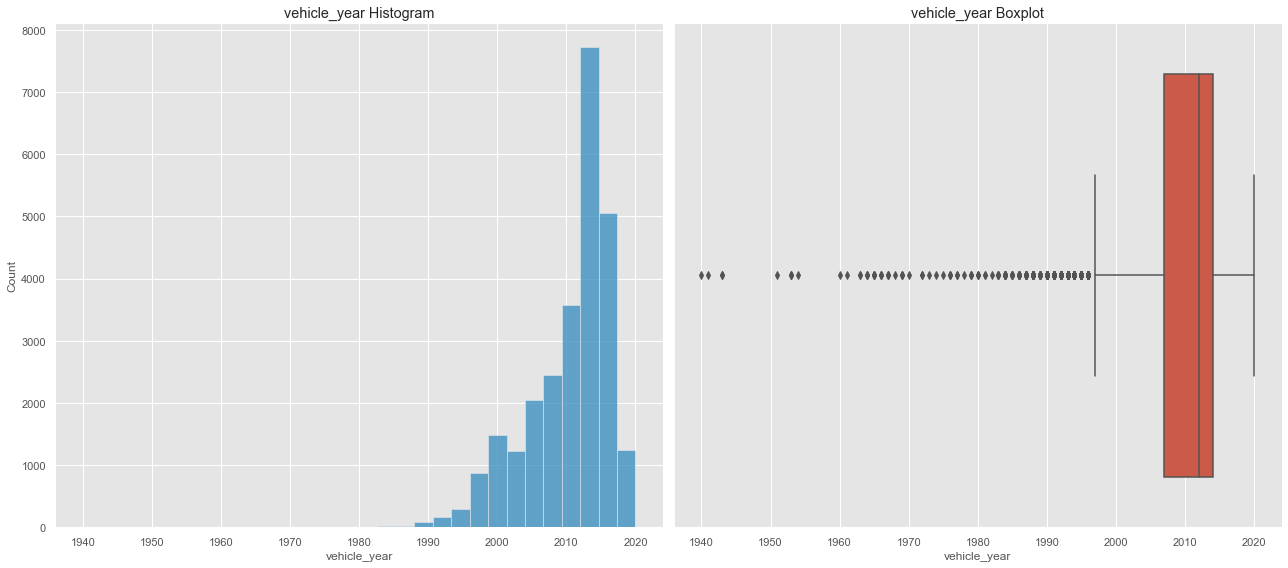

In [30]:
# Смотрю на текущее распределение года выпуска
# Вижу вылеты за пределами усов ниже 1998г примерно
hd.Hist_and_Box_Plots(train_data, 'vehicle_year')

In [31]:
# С помощью группировки по годам посчитаю количество машин выпущенному в каждом году
group_by_year = train_data.groupby('vehicle_year').agg({'vehicle_year': 'count'})
group_by_year.columns = ['Vehicle count']
group_by_year

,Vehicle count
vehicle_year,
1940,1
1941,1
1943,2
1951,1
1953,3
...,...
2016,1890
2017,1216
2018,731


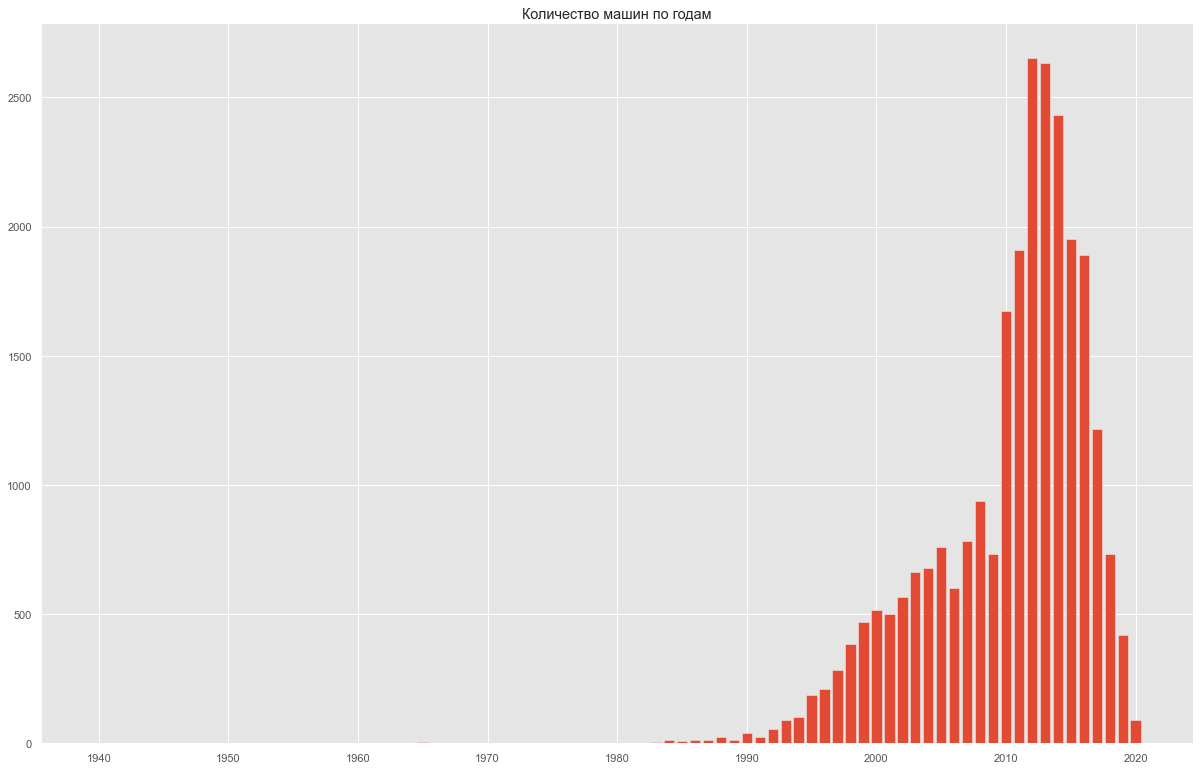

In [32]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(group_by_year.index, group_by_year['Vehicle count'])
ax.set_title('Количество машин по годам');

### Преобразую год выпуска в возраст машины

In [33]:
def age_feature(data):
    data['vehicle_age'] = 2022 - data['vehicle_year']
    data = data.drop(columns=['vehicle_year'], axis=1)
    return data

In [34]:
%%time
train_data = age_feature(train_data)
test_data = age_feature(test_data)

CPU times: total: 15.6 ms
Wall time: 6.01 ms


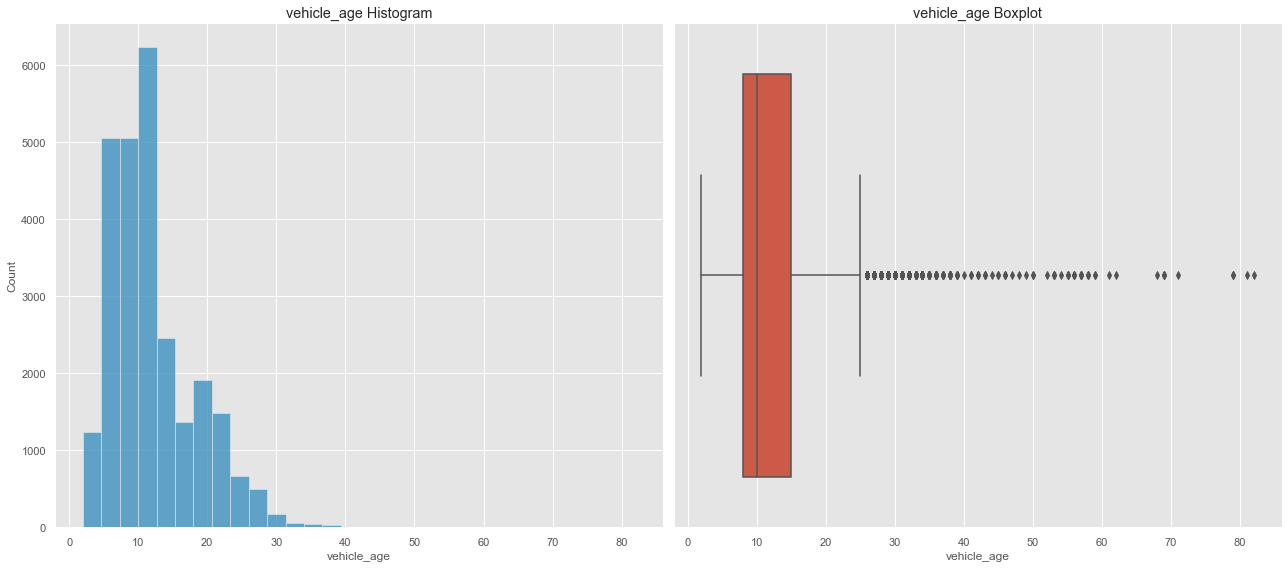

In [35]:
# Смотрю как выглядят распределения возраста
hd.Hist_and_Box_Plots(train_data, 'vehicle_age')

In [36]:
# Использую метод Тьюки
info, outliers, clean_train_data = hd.outliers_iqr(train_data, 'vehicle_age', log_scale=False, left=1.5, right=1)
info

'Выбросы: 1986 строк (7.54%).'

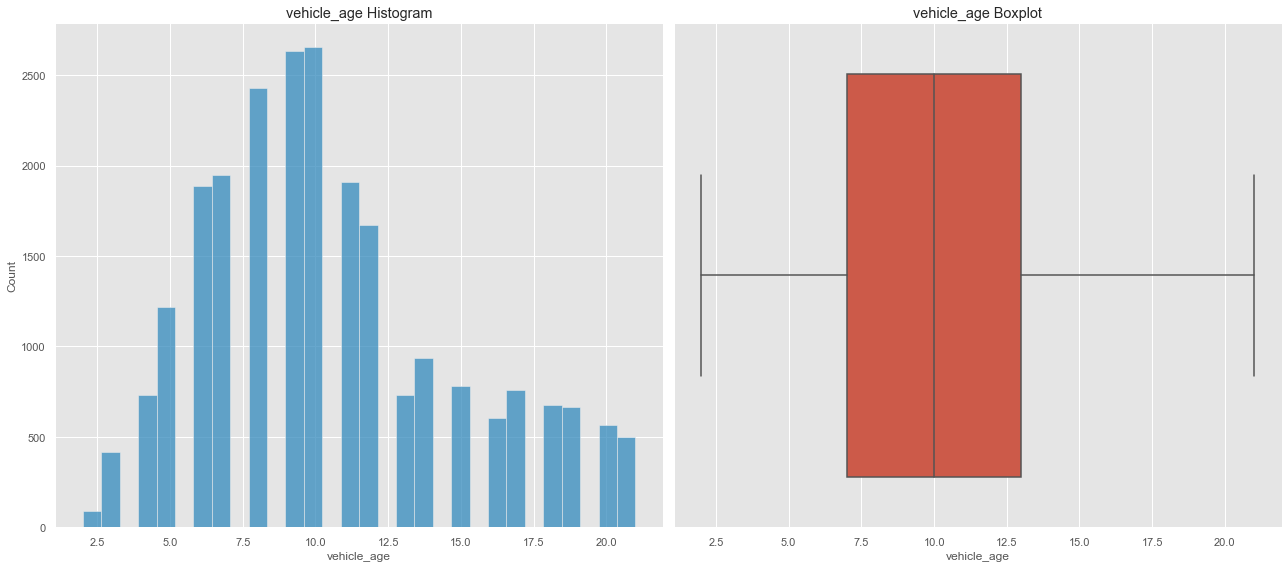

In [37]:
# Смотрю как выглядят распределения возраста для отчищенных данных по методу тьюки
hd.Hist_and_Box_Plots(clean_train_data, 'vehicle_age')

In [38]:
# Использую метод 3х сигм
info, outliers, clean_train_data = hd.outliers_z_score(train_data, 'vehicle_age', log_scale=False, left=3, right=1.5)
info

'Выбросы: 2503 строк (9.51%).'

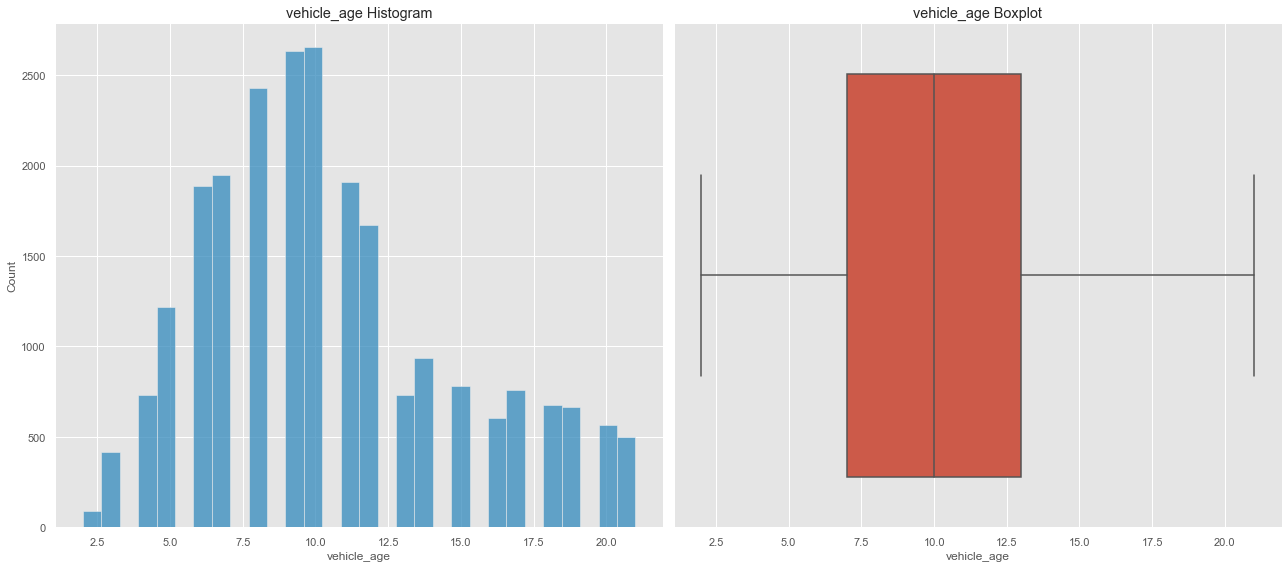

In [39]:
# Смотрю как выглядят распределения возраста для отчищенных данных по методу 3х сигм
hd.Hist_and_Box_Plots(clean_train_data, 'vehicle_age')

In [40]:
# Пока с фильтрацией выбросов ничего не делаю.
# Запускаю этот вариант. Через комет сохраняю.

### Привожу целевую переменную к целому типу, это упростит создание модели 

In [41]:
train_data[TARGET_NAME] = train_data[TARGET_NAME].astype('int')

### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [42]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (21060, 15), te_data = (5266, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age
540,540,LEXUS,GX 460,Jeep,255406,Automatic,4/5,Left wheel,Black,NaN,JTJJM7FX2C5048318,1,For Sale,17400,10
21978,21978,BMW,525,Sedan,250000,Tiptronic,4/5,Left wheel,Green,Grey,NaN,1,For Sale,2900,20
29209,29209,MITSUBISHI,Dion,Minivan,111111,Automatic,4/5,Right-hand drive,Grey,Grey,NaN,0,For Sale,1594,17
28405,28405,OPEL,Astra,Hatchback,17000,Manual,4/5,Left wheel,Red,Black,NaN,0,For Sale,1500,24
16271,16271,MERCEDES-BENZ,G 300,Jeep,138000,Manual,2/3,Left wheel,Black,Black,NaN,0,For Sale,5000,34


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [43]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [44]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID', 'deal_type']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In [45]:
# automl = TabularAutoML(
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [46]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[13:29:05] Start automl utilizator with listed constraints:
[13:29:05] - time: 1800.00 seconds
[13:29:05] - CPU: 4 cores
[13:29:05] - memory: 16 GB

[13:29:05] If one preset completes earlier, next preset configuration will be started

[13:29:05] ==================================================
[13:29:05] Start 0 automl preset configuration:
[13:29:05] c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[13:29:05] Stdout logging level is INFO.
[13:29:05] Task: reg

[13:29:05] Start automl preset with listed constraints:
[13:29:05] - time: 1800.00 seconds
[13:29:05] - CPU: 4 cores
[13:29:05] - memory: 16 GB

[13:29:05] Train data shape: (21060, 15)

[13:29:07] Layer 1 train process start. Time left 1798.01 secs
[13:29:08] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:29:17] Fitting Lvl_0_Pip

In [47]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.39649 * 1 averaged models with config = "c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.15829 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.60626 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.23545 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.60351 * 1 averaged models with config = "c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.76060 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.23940 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 





# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [48]:
%%time
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[25354.547 ],
       [ 8064.073 ],
       [ 4057.21  ],
       ...,
       [ 5064.2974],
       [15795.648 ],
       [ 6711.264 ]], dtype=float32)
Shape = (5266, 1)
CPU times: total: 7.5 s
Wall time: 2 s


In [49]:
mae0 = mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])
print(f'TRAIN out-of-fold score: {mae0}')
experiment.log_metric('TRAIN out-of-fold score', mae0)


mae1 = mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])
print(f'HOLDOUT score: {mae1}')
experiment.log_metric('HOLDOUT score', mae1)

TRAIN out-of-fold score: 2648.598476544314
HOLDOUT score: 4027.6576163729833


prev values:\
TRAIN out-of-fold score: 2434.783417413201\
HOLDOUT score: 2574.981653039796


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [50]:
# %%time
# # Fast feature importances calculation
# fast_fi = automl.get_feature_scores('fast')
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [51]:
# %%time
# # Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
# accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

In [52]:
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

Для более точного предсказания использую весь датасет train_data

In [53]:
# automl = TabularAutoML(
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [54]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1)

[13:50:19] Start automl utilizator with listed constraints:
[13:50:19] - time: 1800.00 seconds
[13:50:19] - CPU: 4 cores
[13:50:19] - memory: 16 GB

[13:50:19] If one preset completes earlier, next preset configuration will be started

[13:50:19] ==================================================
[13:50:19] Start 0 automl preset configuration:
[13:50:19] c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[13:50:19] Stdout logging level is INFO.
[13:50:19] Task: reg

[13:50:19] Start automl preset with listed constraints:
[13:50:19] - time: 1800.00 seconds
[13:50:19] - CPU: 4 cores
[13:50:19] - memory: 16 GB

[13:50:19] Train data shape: (26326, 15)

[13:50:22] Layer 1 train process start. Time left 1797.81 secs
[13:50:23] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:50:35] Fitting Lvl_0_Pip

In [55]:
mae2 = mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])
print(f'FULL TRAIN score: {mae2}')
experiment.log_metric('FULL TRAIN score', mae2)

FULL TRAIN score: 2955.4314700231484


In [56]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 1422.0172],
       [ 5524.6836],
       [ 2934.8242],
       ...,
       [13671.152 ],
       [ 5132.021 ],
       [ 6649.201 ]], dtype=float32)
Shape = (10697, 1)


In [57]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission

,row_ID,final_price
0,35000,1422.02
1,35001,5524.68
2,35002,2934.82
3,35003,644.67
4,35004,4261.58
...,...,...
10692,45692,1272.35
10693,45693,1343.43
10694,45694,13671.15
10695,45695,5132.02


### Проверка и замена нулевой записи

In [58]:
# Должно быть ноль
submission[submission['row_ID'] == 37254]

,row_ID,final_price
2254,37254,8781.12


In [59]:
# Если не ноль, то принудительно меняю
ind = submission[submission['row_ID'] == 37254].index
submission.at[ind, 'final_price'] = 0

In [60]:
submission[submission['row_ID'] == 37254]

ind = submission[submission['row_ID'] == 37254].index
submission.at[ind, 'final_price'] = 0

In [61]:
submission.to_csv('drop_duplicates.csv', index = False)

In [62]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/chepell/predict-car-price/43891437d9054a31b3fa3e067b5b4560
COMET INFO:   Metrics:
COMET INFO:     FULL TRAIN score        : 2955.4314700231484
COMET INFO:     HOLDOUT score           : 4027.6576163729833
COMET INFO:     TRAIN out-of-fold score : 2648.598476544314
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (406.66 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO:     text-sample              : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionali